# Battle of the Neighborhoods
## Pre-processing

__Table of Contents__

* [Introduction](#Introduction)
* [Load venue data](#Load-venue-data)
* [Define distances](#Define-distances)
* [Nearest neighbors for venue categories](#Nearest-neighbors-for-venue-categories)
* [Synthesize datapoints](#Synthesize-datapoints)
* [Compile neighbors](#Compile-neighbors)
* [Save full dataset](#Save-full-dataset)

![](https://vignette.wikia.nocookie.net/phineasandferb/images/9/9b/Treehouse_Fight.jpg/revision/latest?cb=20090320212850)

# For a __Brand New Sports Facility__ in Hyderabad, India


# Introduction

__The story so far...__

In the notebook 'intro_data.ipynb', the [motivation](intro_data.ipynb#Introduction) for building a sports facility was outlined. [Data](intro_data.ipynb#Data) was also collected using Google Place API, and stored in JSON files. 

Ten categories of venues in the city (Hyderabad, India) have been collected. A deliberate decision was made to not clean this data because, reasons. These categories are:

[Sports facilities, cinemas, pubs, gyms, banks, hospitals, supermarkets, schools, colleges, and restaurants](intro_data.ipynb#Points-of-interest-in-Hyderabad).

__In this notebook...__

The model(s) we are going to build are based on distance to 'n' nearest venues of each category. In this notebook, we create nearest neighbors models, define a large set of locations to be used for training and testing, and then find distances to nearest venues for these locations. This data is put in a pandas DataFrame and saved to disk for the next step. 

__In the next notebook...__

Use the data from this notebook to try out different features and output labels with different models.

In [1]:
import json
import numpy as np
import pandas as pd
from geopy.distance import distance
import time # Will use sleep from time to pause 
import matplotlib.pyplot as plt
import folium

from warnings import warn
%matplotlib inline

In [3]:
venueCats = ["sports", "cinemas", "pubs", "gyms", "banks", 
             "hospitals", "supermarkets", "schools", "colleges", "restaurants"]
venueCats = sorted(venueCats, key=str.lower)

# Location of the center of the city: 
# The location of the "Buddha Statue" in a lake called "Hussain Sagar" at the center of the city is used
lat_CC = 17.415435
lng_CC = 78.474296

# Load venue data

This is the data saved in the previous notebook. This data will __not__ have to be split into training and test data. That will come later, when we start assigning labels to datapoints. For now, just read them into dataframes.

In [4]:
dataDict = {}    # Keep dataframes in a dict to make life easier

for key in venueCats:
    df = pd.read_json(key+".json")
    df.sort_values('Dist_CC', axis=0, ascending=True, inplace=True)
    df.reset_index(drop=True,inplace=True)
    dataDict[key] = df

In [5]:
dataDict['pubs'].head(10)

,Name,ID,Latitude,Longitude,View_NE_lat,View_NE_long,View_SW_lat,View_SW_long,Dist_CC
0,H2 The Restro Bar,ChIJ5XDsL1yXyzsRlUvwEK_9ZRw,17.407272,78.468875,17.408658,78.470320,17.405959,78.467620,1071
1,Head Quarters Rest O Bar,ChIJ4Zfn6k2XyzsRTFiKgYzj2ts,17.422160,78.462548,17.423520,78.463939,17.420820,78.461240,1453
2,Kismet,ChIJaesir02XyzsRlZ0dXm9uC4g,17.423237,78.462453,17.424560,78.463792,17.421860,78.461092,1526
3,Hydrate,ChIJl2l9N12XyzsRWQdSRlfWQf4,17.405123,78.464534,17.406532,78.465789,17.403833,78.463090,1542
4,Hotel Meghacity Bar and Restaurant,ChIJq6qqat-ZyzsRwb2gbtJqz7w,17.401491,78.476170,17.402890,78.477377,17.400191,78.474678,1556
5,Eagle Bar & Restaurant,ChIJAQAAwGiXyzsRK7BK7qMn6Iw,17.404695,78.464663,17.406048,78.465883,17.403348,78.463183,1569
6,Aqua,ChIJoVVVFUyXyzsRl2roHpV2Ah4,17.423548,78.462092,17.424789,78.463399,17.422089,78.460700,1577
7,Carbon,ChIJCU7zCk2XyzsRL4fpXHCLQ2k,17.423788,78.462254,17.425248,78.463652,17.422549,78.460953,1578
8,THE SICCA BAR,ChIJcXIcoU2XyzsRkOtZBO6O-Vo,17.423758,78.462007,17.425131,78.463231,17.422432,78.460531,1598
9,Altitude Lounge Bar Hyderabad Marriott Hotel &...,ChIJVSo9b_eZyzsRurdW5Gr6vOQ,17.424267,78.487381,17.425757,78.488892,17.423058,78.486192,1700


Yep, things look like they should. Moving on....


# Define distances

Create a nearest neighbors model to extract venues closest to a specified location. The distance metric is important for nearest neighbors searches. In the previous notebook, we used Geopy's distance() function. Because a lot of calls to this function will be issued, it really helps to find a cheaper (less time consuming) implementation. 

(I'm going to pretend that I was smart enough to realize the importance of the distance metric. What actually happened was, my nearest neighbors was taking WAAAAAAAY TOO LONG. I profiled the code and found that Geopy's distance() was the culprit. Then I tried the following approximate distance metric. This produces fairly good speed up, enough for me to go back and clean up the entire notebook.)

We can approximately calculate distances assuming the earth is spherical, and is locally Euclidean (i.e., Pythagoras theorem holds). How much error do we get under this approximation?

Let's approximate radius of earth as a constant 6,370 km. 

Distance between two points can be approximated using Pythagoras theorem as
$$s = \sqrt{\Delta x ^2 + \Delta y ^2},$$
where $\Delta x$ is the distance along East-West, and $\Delta y$ is the distance along North-South.

The East-West distance can be further approximated using the circumference of the latitude line that runs through the city center (lat=17.4154), 
$$ circ_{lat} = 2 \pi R_{Earth} \cos(17.4154),$$
and dividing this circumference into 360 longitudes, so that
$$\Delta x = \frac{circ_{lat}}{360} |lng_2 - lng_1|.$$

The North-South distance is similarly approximated using the circumference of the Earth (assumed to be spherical) as
$$ \Delta y = \frac{2\pi R_{Earth}}{360}|lat_2 - lat_1| $$


In [6]:
latCC = lat_CC
lngCC = lng_CC

rEarth = 6370000
circEarth = 2.*np.pi*rEarth
rLatCity = rEarth*np.cos(np.pi*latCC/180.)
circLatCity = 2.*np.pi*rLatCity

def approxDistFun(loc1, loc2):
    deltaLat = abs(loc1[0]-loc2[0])
    deltaLng = abs(loc1[1]-loc2[1])
    return np.sqrt( (circEarth/360.*deltaLat)**2  + (circLatCity/360.*deltaLng)**2  )

latTest = 17.3
lngTest = 78.5

# Let's see distances given by the two functions
print("Distance using GeoPy from CC to ({},{}):{:.2f}m".format(
            latTest, lngTest, distance((latCC,lngCC),(latTest,lngTest)).m))
print("Distance using the above function from CC to ({},{}):{:.2f}m".format(
            latTest, lngTest, approxDistFun((latCC,lngCC),(latTest,lngTest))))

Distance using GeoPy from CC to (17.3,78.5):13064.38m
Distance using the above function from CC to (17.3,78.5):13120.24m


The distances look close enough. Does the new implementation provide any reasonable benefit though?

In [7]:
%timeit distance((latCC,lngCC),(latTest,lngTest)).m
%timeit approxDistFun((latCC,lngCC),(latTest,lngTest))

246 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.5 µs ± 30.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Yep. The new function is about 70 times faster. This speed up can make a very real difference to nearest neighbors search. 

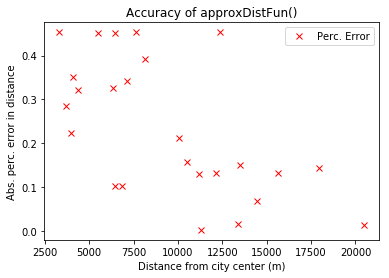

In [8]:
# Compare distance for a bunch of locations from city center to make sure the ranking is adequate.
n_test = 25
loc_min = [17.3, 78.3]
loc_max = [17.5, 78.5]
locArr = np.random.uniform(low=loc_min, high=loc_max, size=(n_test,2))

distArr = np.zeros((locArr.shape[0],2))
for ind in range(distArr.shape[0]):
    distArr[ind,0] = distance( (latCC,lngCC), (locArr[ind,0], locArr[ind,1])  ).m
    distArr[ind,1] = approxDistFun( (latCC, lngCC), (locArr[ind,0], locArr[ind,1])  )

plt.plot(distArr[:,0], np.abs(distArr[:,1]-distArr[:,0])/distArr[:,0]*100., 'rx', label='Perc. Error')
plt.title("Accuracy of approxDistFun()")
plt.xlabel("Distance from city center (m)")
plt.ylabel("Abs. perc. error in distance")
plt.legend()
plt.show()

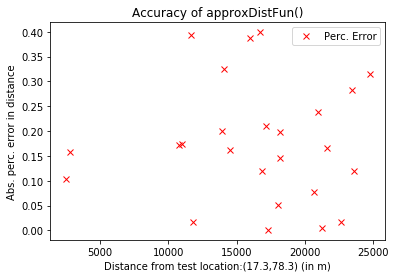

In [9]:
# Compare distance for a bunch of locations from a different location
locTest = (17.3, 78.3)
n_test = 25
loc_min = [17.3, 78.3]
loc_max = [17.5, 78.5]
locArr = np.random.uniform(low=loc_min, high=loc_max, size=(n_test,2))

distArr = np.zeros((locArr.shape[0],2))
for ind in range(distArr.shape[0]):
    distArr[ind,0] = distance( locTest, (locArr[ind,0], locArr[ind,1])  ).m
    distArr[ind,1] = approxDistFun( locTest, (locArr[ind,0], locArr[ind,1])  )

plt.plot(distArr[:,0], np.abs(distArr[:,1]-distArr[:,0])/distArr[:,0]*100., 'rx', label='Perc. Error')
plt.title("Accuracy of approxDistFun()")
plt.xlabel("Distance from test location:({},{}) (in m)".format(locTest[0],locTest[1]))
plt.ylabel("Abs. perc. error in distance")
plt.legend()
plt.show()


Yep. The new function does well. It's 70x faster, and is only off by less than 0.5%. Let's use this function in the nearest neighbors model instead of Geopy's distance.

# Nearest neighbors for venue categories

We plan on building a model that relates distances to nearby venues to the suitability for establishing a sports facility. To make this happen, we need functions that compute these distances for any specified location, obviously. Scikit-learn's unsupervised nearest neighbors models do just that. 

We will define a dictionary containing all of these models. 

In [10]:
from sklearn.neighbors import NearestNeighbors

n_nbrs = 10 # 10 nearest venues. A subset of these will later be used to create features
# Increase this value if needed. 10 should be sufficient though.

# Create a dictionary to hold all of the kNN models.
closestVenueModel = {}

for key in venueCats:
    # Extract latitudes and longitudes from dataframe as a numpy array
    venueLocations = dataDict[key][['Latitude','Longitude']].to_numpy()
    closestVenueModel[key] = NearestNeighbors(n_neighbors=n_nbrs, metric=approxDistFun).fit(venueLocations)       

In [11]:
# Let's see what we get if we ask for venues closest to city center
distances, indices = closestVenueModel['banks'].kneighbors([[lat_CC,lng_CC]])
distances,indices

(array([[1388.01317299, 1514.1742747 , 1554.49886357, 1577.83820498,
         1607.63152371, 1646.9336956 , 1681.39290171, 1697.10146899,
         1727.91896823, 1787.4489072 ]]),
 array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int64))

Yep... We sorted the dataframes already by distance from city center, so the indices must be the first 10. Note that the distances calculated here, using approxDistFun(), differ slightly from the 'Dist_CC' column in the data saved in the previous notebook.

In [12]:
dataDict['banks'].iloc[indices.flat]

,Name,ID,Latitude,Longitude,View_NE_lat,View_NE_long,View_SW_lat,View_SW_long,Dist_CC
0,The Hongkong And Shanghai Banking Corporation ...,ChIJvwWaYkyXyzsRbwJxN4y4bso,17.418570,78.461631,17.419927,78.462959,17.417228,78.460259,1390
1,Union Bank Of India,ChIJL_wg6X6XyzsRr3PTAhKPr_0,17.423035,78.462451,17.424445,78.463825,17.421746,78.461125,1514
2,State Bank of India,ChIJtzBdjUWXyzsRlLW3KmGUbXs,17.414220,78.459698,17.415499,78.461250,17.412800,78.458550,1557
3,Kotak Mahindra Bank,ChIJlaE4SlyXyzsRaFacSlBzmks,17.413222,78.459604,17.414546,78.460877,17.411846,78.458177,1580
4,hfcs Bank,ChIJc2a1yUWXyzsR7fP5jUqmr94,17.412425,78.459473,17.413709,78.460858,17.411009,78.458158,1610
5,Yes Bank,ChIJJxaCq02XyzsRAyHFroORqRE,17.423327,78.461158,17.424571,78.462487,17.421871,78.459788,1647
6,State Bank Of Mauritius Limited,ChIJ3_7dVEyXyzsRAYiqtdnlrd4,17.423521,78.460901,17.424693,78.462214,17.421994,78.459515,1681
7,Canara Bank,ChIJyTpmUEyXyzsRz67TSX0kAQc,17.422913,78.460349,17.424377,78.461717,17.421677,78.459017,1697
8,State Bank of India భారతీయ స్టేట్ బ్యాంక్,ChIJnb28T0uXyzsRCztN8otRUts,17.423393,78.460305,17.424741,78.461668,17.422041,78.458968,1728
9,South Indian Bank,ChIJedIKW0yXyzsR8MqogFvd9qc,17.423300,78.459600,17.424628,78.460944,17.421929,78.458245,1788


In [13]:
# Let's try a different location
lat = 17.5
lng = 78.5
venueCat = "schools"
print("Finding {} closest {} to ({},{})...".format(n_nbrs,venueCat,lat, lng))
distances, indices = closestVenueModel[venueCat].kneighbors([[lat,lng]])
closestSchools_test = dataDict[venueCat][['Latitude','Longitude']].iloc[indices.flat].values
distances_test = [approxDistFun((lat,lng), tuple(row)) for row in closestSchools_test]

print("{:9s}, {:9s}, {:7s}".format("Latitude", "Longitude", "Dist"))
for ix in range(n_nbrs):
    print("{:9.5f}, {:9.5f}, {:7.1f}".format(closestSchools_test[ix,0], closestSchools_test[ix,1], distances_test[ix]))

Finding 10 closest schools to (17.5,78.5)...
Latitude , Longitude, Dist   
 17.49901,  78.49971,   114.2
 17.50514,  78.50192,   607.1
 17.50687,  78.50025,   764.5
 17.50650,  78.50280,   781.0
 17.50590,  78.50464,   819.5
 17.50640,  78.49585,   837.0
 17.50529,  78.50606,   871.3
 17.49446,  78.50605,   890.0
 17.50793,  78.49884,   890.3
 17.50628,  78.50532,   897.5


A bunch of schools within a kilometre, sorted by distance. Looks okay to me. That's all the __"testing"__ we'll do here.

While I'm at it, I'll also define a function that produces a map of venues around a location.

In [14]:
def showNearbyVenues(venueCat, latLoc, lngLoc):
    # Get indices of nearest venues of category venueCat
    indices = closestVenueModel[venueCat].kneighbors([[latLoc,lngLoc]])[1]
    
    # Get locations from dataDict
    df = dataDict[venueCat].iloc[indices.flat]
    map_venues = folium.Map(
        location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=14)
    
    label = folium.Popup("Query Loc:({},{})".format(latLoc,lngLoc), parse_html=True)
    folium.Marker(
            [latLoc, lngLoc],
            popup=label, icon=folium.Icon(color='red')).add_to(map_venues)
    for lat, lon,name in zip(df['Latitude'], df['Longitude'], df['Name']):
        label = folium.Popup(str(name), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=8,
            popup=label,
            fill=True,
            fill_opacity=0.7).add_to(map_venues)
       
    return map_venues

In [16]:
showNearbyVenues('pubs', 17.42, 78.36)

# Synthesize datapoints

To train and to test the model, we need datapoints that have a range of suitability scores. We will build these datasets in three steps.

1. Use the locations of all of the existing sports facilities. These locations should have $S=1$
2. Randomly select a lot of locations within the city (numpy's rand.uniform). These locations should have $0< S \leq 1$.
3. Split the above set into a training set and a test set. The training set can later be split into validation sets for cross validation. 

The assignment of suitability scores to the locations is discussed during feature selection in the next notebook.

So, how many randomly selected points? Let's have 10x the number of existing sports facilities. Why? Because this puts the total number of datapoints at about 8000. That sounds like a good number of datapoints to have for this project. After all, the locations have only two spatial coordinates, and the extracted feature vectors can be between 9 and 90 (9 if we use one measure of distance for each venue category, 90 if we use all 10 nearest neighbor distances for each category). 8000+ datapoints for 9 features sounds pretty good, and is pretty decent even for 90.

If 8000+ datapoints aren't enough, I can always come back and increase the number of datapoints. If you, the reader, are feeling a bit adventurous, you could even use datapoints from other cities in India to supplement this dataset. 

__There is a case to be made for using a normal distribution of locations instead of a uniform distribution, so datapoints are clustered around the city center. We will not explore this case.__

In [17]:
n_exLoc = len(dataDict['sports'])  # Number of existing sports facilities
n_rand = 10*n_exLoc
n_total = n_exLoc + n_rand

# Define boundaries for the city, (lat0, long0) at south-west, (lat1, long1) north-east    
lat0 = 17.2
lng0 = 78.15
lat1 = 17.6
lng1 = 78.7

# Existing locations
q0 = dataDict['sports'][['Latitude','Longitude']].to_numpy()

# Random locations, uniformaly distributed
loc_min = [lat0, lng0]
loc_max = [lat1, lng1]
np.random.seed(0)   
q1 = np.random.uniform(low=loc_min, high=loc_max, size=(n_rand,2))

# The full set of locations (latitude,longitude) of shape (n_total, 2)
q = np.concatenate((q0,q1), axis=0)
np.random.shuffle(q)   # Shuffle rows in-place

In [22]:
q.shape

(8030, 2)

In [19]:
# Plot first 100 locations in dataset
map_tmp = folium.Map(
    location=[lat_CC, lng_CC], zoom_start=10)

for ind in range(100):
    folium.CircleMarker(
        [q[ind,0], q[ind,1]],
        radius=3,
        fill=True,
        fill_opacity=0.7).add_to(map_tmp)

print("First 100 locations from the shuffled dataset")    
map_tmp

First 100 locations from the shuffled dataset


# Compile neighbors

In [23]:
# q is the set of locations to be used for training/testing the model.
# Convert all data into lists, and then initialize dataframe using these lists.
qList = list(q) # Each element of this list is a numpy array of shape (2,) for (latitude,longitude)

# Now create a dict to hold distances to neighboring venues
nbrDict = {}
for key in venueCats:
    nbrDict[key] = [] #Initialize empty list

# For every location in q, append list containing distance to n_nbrs neighbors
for key in venueCats:
    for loc in qList:
        nbrDict[key].append(
            closestVenueModel[key].kneighbors( [ [loc[0],loc[1]] ] )[0].flatten()   )
nbrDict['Location'] = qList
df_data = pd.DataFrame.from_dict(nbrDict)
df_data.head()

,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets,Location
0,"[594.4527836578303, 912.3336302107255, 1194.51...","[2522.692682216959, 2744.1248318103326, 3292.8...","[2223.144595847463, 2432.6837455658156, 2558.6...","[414.1267292635818, 646.9971330535193, 1470.68...","[2420.9027735319205, 2635.6289195457243, 2651....","[432.6443585269782, 2016.122814208569, 2019.37...","[2836.5380394653034, 2836.5380394653034, 3616....","[370.9854835867171, 571.9475071385789, 581.965...","[988.785947747989, 1586.4883539320624, 1615.91...","[1523.9640962361245, 2093.0682861625974, 2411....","[17.533391550337353, 78.30194800940666]"
1,"[675.4174845325543, 690.9662964703823, 746.231...","[4242.9786786856275, 4506.120499155057, 7748.3...","[131.6769685950299, 1844.253513884675, 3906.78...","[146.70746308983945, 1084.13523730414, 1672.83...","[3828.7129507549234, 4527.567400720657, 4531.0...","[4533.506935941506, 4741.359751270817, 8746.39...","[10352.002863556821, 16951.942846263024, 16951...","[523.7399309266267, 531.6808758280088, 924.419...","[0.0, 18.02244401185628, 31.93785841158319, 96...","[13909.555090598602, 13914.201270681724, 14333...","[17.4942544, 78.1426446]"
2,"[900.0320731504232, 1112.1263350936188, 1862.2...","[3519.4393821484105, 4006.9656695296767, 5006....","[1173.1229865782263, 1205.7817414242486, 2164....","[1279.1132020442205, 1872.6760030303428, 2292....","[3357.0045414089036, 4628.728949398804, 5163.2...","[1813.1426113966343, 2393.7334794761496, 3102....","[4588.722977672582, 4995.786831761858, 4995.95...","[643.1877033490678, 907.7973065666143, 978.754...","[2113.1838554216047, 2186.7739320077294, 2265....","[2894.521932987467, 3085.8676105521918, 3297.4...","[17.560491049554074, 78.47880893577005]"
3,"[1952.0964571433121, 2529.5671991582317, 2541....","[2647.606326415464, 7218.344678896003, 7878.62...","[1487.846932405914, 2154.263125351196, 2163.54...","[3860.5697579887824, 4448.719670933154, 6286.4...","[1949.099336215701, 2529.2656169369543, 6273.9...","[3938.2418895588416, 6656.92058611222, 6993.73...","[6757.999703346962, 10917.154746216753, 10917....","[1194.104873758703, 1457.790883648911, 1460.67...","[4226.235954295309, 4501.284194698018, 4542.04...","[9143.323881625225, 10226.474820693333, 10591....","[17.484874162860546, 78.20175775224313]"
4,"[1858.777870652394, 2070.2786994766657, 2073.8...","[3057.6294049229596, 3179.231679566235, 3646.6...","[859.1360147709762, 1181.503056525121, 1272.37...","[1585.5157198378238, 2986.405019809322, 3009.0...","[2891.267661037422, 2973.9750212486524, 3015.1...","[2567.2689547450677, 4394.428923668142, 4724.1...","[2875.2955888787583, 6334.237168437588, 6597.7...","[746.0853468541576, 975.2616480607813, 1084.11...","[1933.2766651463546, 2415.7321275729337, 2454....","[2966.8760226600984, 3695.570670443937, 4114.7...","[17.36214943313942, 78.32657364452378]"


In [24]:
# Add latitude, longitude, and label
df_data['Latitude'] = [row[0] for row in df_data['Location']]
df_data['Longitude'] = [row[1] for row in df_data['Location']]

# The order of columns is a bit messy. Reorder them.
orderDesired = ["Location", "Latitude", "Longitude"] + venueCats
df_data = df_data[orderDesired]
df_data.head()

,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.533391550337353, 78.30194800940666]",17.533392,78.301948,"[594.4527836578303, 912.3336302107255, 1194.51...","[2522.692682216959, 2744.1248318103326, 3292.8...","[2223.144595847463, 2432.6837455658156, 2558.6...","[414.1267292635818, 646.9971330535193, 1470.68...","[2420.9027735319205, 2635.6289195457243, 2651....","[432.6443585269782, 2016.122814208569, 2019.37...","[2836.5380394653034, 2836.5380394653034, 3616....","[370.9854835867171, 571.9475071385789, 581.965...","[988.785947747989, 1586.4883539320624, 1615.91...","[1523.9640962361245, 2093.0682861625974, 2411...."
1,"[17.4942544, 78.1426446]",17.494254,78.142645,"[675.4174845325543, 690.9662964703823, 746.231...","[4242.9786786856275, 4506.120499155057, 7748.3...","[131.6769685950299, 1844.253513884675, 3906.78...","[146.70746308983945, 1084.13523730414, 1672.83...","[3828.7129507549234, 4527.567400720657, 4531.0...","[4533.506935941506, 4741.359751270817, 8746.39...","[10352.002863556821, 16951.942846263024, 16951...","[523.7399309266267, 531.6808758280088, 924.419...","[0.0, 18.02244401185628, 31.93785841158319, 96...","[13909.555090598602, 13914.201270681724, 14333..."
2,"[17.560491049554074, 78.47880893577005]",17.560491,78.478809,"[900.0320731504232, 1112.1263350936188, 1862.2...","[3519.4393821484105, 4006.9656695296767, 5006....","[1173.1229865782263, 1205.7817414242486, 2164....","[1279.1132020442205, 1872.6760030303428, 2292....","[3357.0045414089036, 4628.728949398804, 5163.2...","[1813.1426113966343, 2393.7334794761496, 3102....","[4588.722977672582, 4995.786831761858, 4995.95...","[643.1877033490678, 907.7973065666143, 978.754...","[2113.1838554216047, 2186.7739320077294, 2265....","[2894.521932987467, 3085.8676105521918, 3297.4..."
3,"[17.484874162860546, 78.20175775224313]",17.484874,78.201758,"[1952.0964571433121, 2529.5671991582317, 2541....","[2647.606326415464, 7218.344678896003, 7878.62...","[1487.846932405914, 2154.263125351196, 2163.54...","[3860.5697579887824, 4448.719670933154, 6286.4...","[1949.099336215701, 2529.2656169369543, 6273.9...","[3938.2418895588416, 6656.92058611222, 6993.73...","[6757.999703346962, 10917.154746216753, 10917....","[1194.104873758703, 1457.790883648911, 1460.67...","[4226.235954295309, 4501.284194698018, 4542.04...","[9143.323881625225, 10226.474820693333, 10591...."
4,"[17.36214943313942, 78.32657364452378]",17.362149,78.326574,"[1858.777870652394, 2070.2786994766657, 2073.8...","[3057.6294049229596, 3179.231679566235, 3646.6...","[859.1360147709762, 1181.503056525121, 1272.37...","[1585.5157198378238, 2986.405019809322, 3009.0...","[2891.267661037422, 2973.9750212486524, 3015.1...","[2567.2689547450677, 4394.428923668142, 4724.1...","[2875.2955888787583, 6334.237168437588, 6597.7...","[746.0853468541576, 975.2616480607813, 1084.11...","[1933.2766651463546, 2415.7321275729337, 2454....","[2966.8760226600984, 3695.570670443937, 4114.7..."


# Save full dataset

Save DataFrame to disk as JSON. This data is used in the next notebook to build and evaluate a bunch of models

In [25]:
saveName = "fullDataSet.json"
df_data.to_json(saveName)